# **Pràctica Bloc III: Aerolínies i Satisfacció**

---



In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time

### 1. Càrrega de dades

Carregam el conjunt d'entrenament (`train.csv`) i de prova (`test.csv`) per separat. Per fer més fàcil el preprocesament, unificam els dos conjunts amb una columna extra `is_train` per diferenciar-los. Això assegura que la codificació i neteja de dades serà igual als dos conjunts.

In [20]:
# --- 1. CÀRREGA DE DADES  ---
# Llegim les dades de train.csv y test.csv
df_train_raw = pd.read_csv("train.csv", sep=',', index_col=0, engine='python', on_bad_lines='skip')
df_test_raw = pd.read_csv("test.csv", sep=',', index_col=0, engine='python', on_bad_lines='skip')

# Marcam quines dades son les d'entrenament i quines no
df_train_raw['is_train'] = True
df_test_raw['is_train'] = False

# Unim els dos fitxers en una variable per poder-ho processar
df_full = pd.concat([df_train_raw, df_test_raw], axis=0)

### 2. Neteja de Dades

Aquesta secció s'enfoca en la preparació de les dades per al seu ús en els models:

*   **Eliminació de Columnes Redundants**: S'elimina la columna 'id' ja que no aporta informació predictiva.
*   **Tractament de Valors Nuls**: 'Arrival Delay in Minutes' té valors faltants, per això s'umplen amb la mediana de la columna. Qualsevol altra NaN en columnes numèriques s'umpl igualment para asegurar la integritat de les dades.
*   **Codificació de Variables Categòriques**:
    *   La variable objectiva'satisfaction' es converteix a numèrica (0/1) utilitzant `LabelEncoder`.
    *   La columna 'Class' se mapetja manualment a valors numèrics (0, 1, 2).
    *   Las columnes categòriques nominals ('Gender', 'Customer Type', 'Type of Travel') se transformen utilitzant One-Hot Encoding (`pd.get_dummies`), eliminant una de les categories.
    *   Las columnas de text valoracionals es convierteixen a numèriques, tractant els valors no numèrics com 0.

In [21]:
# --- 2. NETEJA DE DADES (APLICADA A TOT) ---
# Eliminam la columna de id
df_full = df_full.drop(['id'], axis=1, errors='ignore')

# Omplim NaNs de Arrival Delay in Minutes amb la mediana
for col in ['Arrival Delay in Minutes']:
    df_full[col] = df_full[col].fillna(df_full[col].median())

# Encode de la columna de satisfaction(rankeats)
le = LabelEncoder()
df_full['satisfaction'] = le.fit_transform(df_full['satisfaction'])

# Encode de la columna Class 
class_map = {'Eco': 0, 'Eco Plus': 1, 'Business': 2}
df_full['Class'] = df_full['Class'].map(class_map)

# Encoding One-Hot per a Gender, Customer Type i Type of Travel (One Hot ja que no es pot fer un ranking)
df_full = pd.get_dummies(df_full, columns=['Gender', 'Customer Type', 'Type of Travel'], drop_first=True)

# Encode de altres dades
for col in df_full.columns:
    if df_full[col].dtype == 'object':
        # Convertim a numero neutral or dissatisfied, si hi ha alguna paraula que no es pot passar posa un NaN
        df_full[col] = pd.to_numeric(df_full[col].replace('neutral or dissatisfied', 0), errors='coerce')
        #Posam un 0 als Nans
        df_full[col] = df_full[col].fillna(0)

# Fa un darrer cicle per comprobar que no hi hagin NaNs
for col in df_full.columns:
    if df_full[col].dtype in ['int64', 'float64'] and df_full[col].isnull().any():
        median_val = df_full[col].median()
        if pd.isna(median_val):
            df_full[col] = df_full[col].fillna(0)
        else:
            df_full[col] = df_full[col].fillna(median_val)

### 3. Separación Final de Datos

Una vez que los datos han sido limpiados y preprocesados en el conjunto combinado (`df_full`), se procede a separarlos de nuevo en `df_train` y `df_test`, utilizando la columna 'is_train' que se añadió al inicio. Esto nos permite tener conjuntos de datos listos para el entrenamiento y la evaluación final, asegurando que el conjunto de prueba permanezca virgen hasta el final del proceso.

In [22]:
# --- 3. SEPARACIÓ FINAL ---
# Tornam a separar els tests dels trains
df_train = df_full[df_full['is_train'] == True].drop('is_train', axis=1)
df_test = df_full[df_full['is_train'] == False].drop('is_train', axis=1)

#Imprimim les dades
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (103904, 23)
Test shape: (25976, 23)



## 4. Anàlisi Exploratòria i Clustering

Aquesta secció realitza una anàlisi exploratòria de dades (EDA) i un clustering, centrant-se exclusivament en el conjunt d'entrenament per evitar la fuga d'informació (*data leakage*) del conjunt de prova:

* **Normalització per al Clustering**: Les característiques del conjunt d'entrenament (excloent la variable objectiu `satisfaction`) s'escalen utilitzant `StandardScaler`. Això és fonamental per a algorismes com K-Means, que són sensibles a l'escala de les variables.
* **Aplicació de K-Means**: S'aplica l'algorisme K-Means per agrupar els passatgers en clústers (en aquest exemple, 3 clústers). L'etiqueta de clúster s'afegeix al DataFrame `df_train`.
* **Visualització amb PCA**: Per visualitzar els clústers en 2D, s'utilitza l'Anàlisi de Components Principals (PCA). Un gràfic de dispersió mostra com s'agrupen els passatgers en l'espai dels dos primers components principals, acolorits pel seu clúster assignat.
* **Anàlisi de Perfils de Clústers**: Es presenta una taula que mostra les mitjanes d'algunes característiques clau (`Flight Distance`, `Class`, `satisfaction`) per a cada clúster. Això ajuda a interpretar les característiques distintives de cada grup de passatgers.

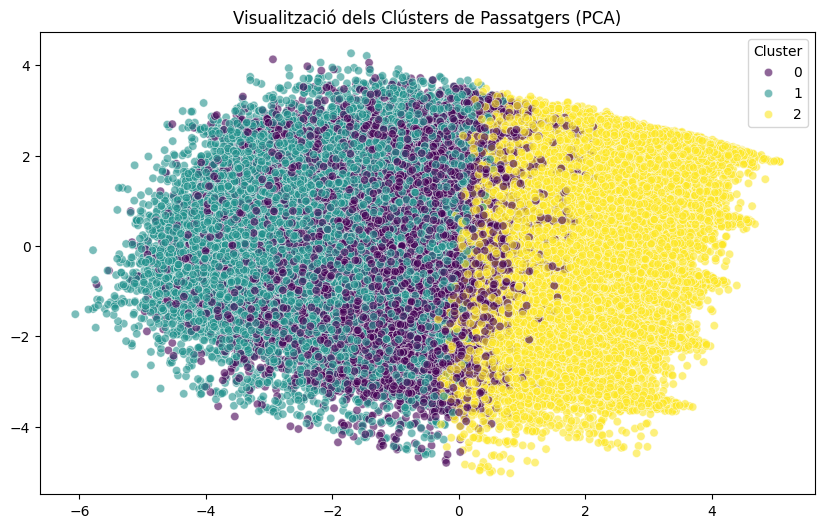

Perfil dels Clústers (Mitjanes):


,Flight Distance,Class,satisfaction
Cluster,,,
0,1054.954351,0.777827,0.253533
1,841.420100,0.564509,0.157743
2,1523.759960,1.525628,0.751862


In [23]:
# --- 4. EDA I CLUSTERING (TRAIN) ---

#Passam totes les variables a una mateixa escala (Ex:wifi i km)
scaler_cluster = StandardScaler()
# Eliminam la columna satisfaction per analitzar els grups amb els altres parametres
X_cluster = df_train.drop(['satisfaction'], axis=1)

# CORRECCIÓN: Rellenar cualquier NaN restante en X_cluster antes de escalar
# Esto es crucial ya que K-Means no acepta NaNs.
for col in X_cluster.columns:
    if X_cluster[col].isnull().any():
        median_val = X_cluster[col].median()
        if pd.isna(median_val): # Si la mediana es NaN (ej. la columna entera es NaN)
            X_cluster[col] = X_cluster[col].fillna(0)
        else:
            X_cluster[col] = X_cluster[col].fillna(median_val)

X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# K-Means (3 clústers)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# Realització del K-means amb els tres punts (clusters)
df_train['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Conversio a grafica (PCA)
pca = PCA(n_components=2) #x e y
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_train['Cluster'], palette='viridis', alpha=0.6)
plt.title("Visualització dels Clústers de Passatgers (PCA)")
plt.show() #Mostram el grafic

# Imprimim l'analisi dels perfils
print("Perfil dels Clústers (Mitjanes):")
display(df_train.groupby('Cluster')[['Flight Distance', 'Class', 'satisfaction']].mean())

### 5. Preparació per a l'Entrenament de Models

En aquesta secció, preparem les dades per a l'entrenament dels nostres models de classificació.

* **Definició de Conjunts de Dades**: Creem `X_train`, `y_train`, `X_test` i `y_test` a partir dels DataFrames `df_train` i `df_test` que hem preprocessat prèviament. És important destacar que eliminem la columna 'Cluster' de `X_train` ja que aquesta informació no estarà disponible en el conjunt de prova per a la predicció.
* **Escalat de Dades**: Utilitzem `StandardScaler` per normalitzar les característiques. Això és crucial per a molts algorismes d'aprenentatge automàtic, especialment aquells basats en distàncies (com SVM o Perceptron), ja que ajuda a fer que convergeixin més ràpid i evita que les característiques amb rangs de valors més grans dominin el càlcul de distàncies. L'escalador s'entrena (`fit`) només amb les dades d'entrenament (`X_train`) i després s'aplica (`transform`) tant a les dades d'entrenament com a les de prova (`X_test`) per evitar la fuga de dades.

In [24]:
# --- 5. PREPARACIÓ PER A L'ENTRENAMENT ---
# Eliminam satisfaction(el que volem endivinar), i cluster(creada anteriorment)
# Les guardam a una variable
X_train = df_train.drop(['satisfaction', 'Cluster'], axis=1)
y_train = df_train['satisfaction']
X_test = df_test.drop(['satisfaction'], axis=1, errors='ignore')
y_test = df_test['satisfaction']

# El model apren les escales de les dades
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Diccionari de models (3 valors per paràmetre)
models_params = {
    'Perceptron': {
        'model': Perceptron(random_state=42),
        'params': {
            'penalty': ['l2', 'l1', 'elasticnet'],     
            'alpha': [0.0001, 0.001, 0.01]             
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {
            'C': [0.1, 1, 10],                         
            'solver': ['liblinear', 'lbfgs', 'newton-cg'] 
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 10, 20],                  
            'min_samples_leaf': [1, 5, 10]             
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],            
            'max_depth': [10, 20, 30]                  
        }
    },
    
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],                         
            'kernel': ['rbf', 'poly', 'sigmoid']       
        }
    }
}

### 6. Configuració i Entrenament de Models

Aquí definim diversos models de classificació populars juntament amb un conjunt d'hiperparàmetres per ajustar mitjançant `GridSearchCV`.

* **Models i Paràmetres**: Hem seleccionat cinc models: Perceptron, Regressió Logística, Arbre de Decisió, Random Forest i Màquines de Vectors de Suport (SVM). Per a cadascun, s'especifiquen tres valors per a dos hiperparàmetres clau, la qual cosa permet a `GridSearchCV` explorar diferents configuracions.
* **Bucle d'Entrenament amb GridSearchCV**: S'itera sobre cada model. Per accelerar el procés d'ajust d'hiperparàmetres (`GridSearchCV`), utilitzem un subconjunt de les dades d'entrenament (`X_tune`, `y_tune`) de 10.000 mostres. `GridSearchCV` realitza una cerca exhaustiva dels millors hiperparàmetres utilitzant validació creuada (3 folds en aquest cas) i selecciona el model amb el millor rendiment (`scoring='accuracy'`).
* **Avaluació Final**: Un vegada es troba el `best_estimator_` (el millor model amb els hiperparàmetres òptims), s'utilitza per predir sobre el conjunt de prova *complet* (`X_test_scaled`) per obtenir una mètrica de precisió (`accuracy_score`) real del rendiment generalitzat del model. Els resultats s'emmagatzemen i s'imprimeixen a mesura que avança l'entrenament.

In [25]:
# --- 6. BUCLE D'ENTRENAMENT ---
#Inicialitzam llistes
results = []
best_classifiers = {}

print(" Començant entrenament...")

#Bucle que recorr tot el de models
for name, mp in models_params.items():
    start = time.time() #guardam el temps

    # Utilitzem un subset per al GridSearch (Tuning) per velocitat
    # Però avaluem finalment sobre TOT el test set.

    # Utilitzem nomes 10000 dades per que no tardi massa
    if len(X_train_scaled) > 10000:
        X_tune = X_train_scaled[:10000]
        y_tune = y_train[:10000]
    else:
        X_tune = X_train_scaled
        y_tune = y_train

    # GridSearch (per a cada model agafa les 100000 dades i s'ENTRENA)
    grid = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_tune, y_tune) # Li passam l'entrada i la resposta

    #Guardam el millor model per llavors imprimir-lo
    best_model = grid.best_estimator_
    best_classifiers[name] = best_model

    # Aqui la IA fa la seva prediccio
    y_pred = best_model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)

    #Guardam les dades
    results.append({
        'Model': name,
        'Test Accuracy': test_acc,
        'Best Params': grid.best_params_
    })

    #Les imprimim per pantalla
    print(f" {name}: Acc={test_acc:.4f} | Temps: {time.time()-start:.1f}s")


 Començant entrenament...
 Perceptron: Acc=0.8123 | Temps: 5.8s
 Logistic Regression: Acc=0.8698 | Temps: 0.4s
 Decision Tree: Acc=0.9349 | Temps: 0.6s
 Random Forest: Acc=0.9508 | Temps: 7.5s
 SVM: Acc=0.9428 | Temps: 12.7s


### 7. Visualització i Anàlisi de Resultats

Finalment, aquesta secció s'encarrega de presentar els resultats obtinguts de la fase d'entrenament i avaluació.

* **Taula de Resultats**: Es crea un `DataFrame` (`results_df`) que resumeix la precisió de cada model en el conjunt de prova i els millors hiperparàmetres trobats. Aquesta taula s'ordena de major a menor precisió per identificar fàcilment el model amb millor rendiment.
* **Matriu de Confusió**: Es genera una matriu de confusió per al model guanyador (el que ha obtingut la major precisió en el conjunt de prova). La matriu de confusió és una eina visual molt útil per entendre el tipus d'errors que comet el model (falsos positius, falsos negatius) i la distribució de les prediccions correctes.

,Model,Test Accuracy,Best Params
3,Random Forest,0.950839,"{'max_depth': 30, 'n_estimators': 200}"
4,SVM,0.942832,"{'C': 10, 'kernel': 'rbf'}"
2,Decision Tree,0.934940,"{'max_depth': 10, 'min_samples_leaf': 1}"
1,Logistic Regression,0.869764,"{'C': 10, 'solver': 'liblinear'}"
0,Perceptron,0.812327,"{'alpha': 0.0001, 'penalty': 'elasticnet'}"



Matriu de Confusió del guanyador: Random Forest


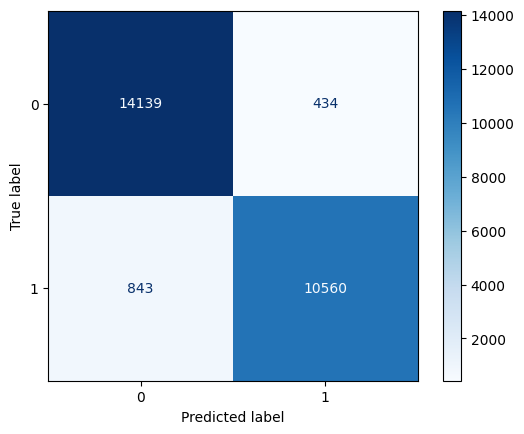

In [26]:

# --- 7. VISUALITZACIÓ DE RESULTATS ---
# Imprimim una taula amb els resultats
results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
display(results_df)

# Matriu de confusió del millor model
best_name = results_df.iloc[0]['Model']
print(f"\nMatriu de Confusió del guanyador: {best_name}")
ConfusionMatrixDisplay.from_estimator(best_classifiers[best_name], X_test_scaled, y_test, cmap='Blues')
plt.show()